<a href="https://colab.research.google.com/github/Msaleemakhtar/Deep-Learning-with-pytorch/blob/main/06_Vision_transformer(Vit).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Replicating Vision Transformer(Vit) Paper with Pytorch**

* https://github.com/lucidrains/vit-pytorch
vit-pytorch repository on GitHub by lucidrains is one of the most extensive resources of different ViT architectures implemented in PyTorch

* https://arxiv.org/pdf/2010.11929
AN IMAGE IS WORTH 16X16 WORDS:
TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE

* https://arxiv.org/pdf/1706.03762
Attention Is All You Need

* Use mathpix.com (a very handy tool) to turn any sections of the paper into markdown/LaTeX to put into notebooks.
https://accounts.mathpix.com/login?return_to=https%3A%2F%2Fsnip.mathpix.com%2F


# ***Get the data***

In [1]:
# Check if CUDA (NVIDIA GPU) is available
# If CUDA is available, set the device to "cuda" to utilize the GPU
# If CUDA is not available, set the device to "cpu

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [2]:
# Download data
import os
import zipfile
import requests
from pathlib import Path

def download_data(source:str, destination:str, remove_source:bool=True)->Path:

  #setup path to data folder
  data_path = Path("data/")

  image_path = data_path/destination

  print("imagepath ", image_path)

  # if directory doesn't exist , download and prepare it
  if image_path.is_dir():
    print(f"[INFO]{image_path} already exist, skipp the download")

  else:
    print(f"[INFO] doesn't exist {image_path} downloading ........")
    image_path.mkdir(parents= True, exist_ok=True)

    # download steak, sushi, pizza
    target_file = Path(source).name

    with open(data_path/target_file, "wb") as f:
      print(f"[INFO] downloading {target_file} from {source}")
      request = requests.get(source)
      f.write(request.content)

      # unzip file
    with zipfile.ZipFile(data_path/target_file, "r") as ref_zip:
      print(f"[INFO] unzipping {target_file}..............")
      ref_zip.extractall(image_path)

    # remove .zip file
    if remove_source:

      os.remove(data_path/target_file)



  return image_path

In [3]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path


imagepath  data/pizza_steak_sushi
[INFO]data/pizza_steak_sushi already exist, skipp the download


PosixPath('data/pizza_steak_sushi')

In [4]:
# setup directories for tain and test data
train_dir = image_path /'train'
test_dir = image_path/ 'test'

In [5]:
train_dir

PosixPath('data/pizza_steak_sushi/train')

In [6]:
!pip install torchinfo

In [7]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms, datasets
from torchinfo import summary
from torch.utils.data import DataLoader

# Pre_processing of Data

**1. IMAGE TRANSFORMATION**
 * a transformation pipeline created using torchvision.transforms.
 * transforms.Compose-----> is a function that allows you to chain multiple image transformations together.


 * transforms.Resize((IMG_SIZE, IMG_SIZE))--->
This transformation resizes the image to the dimensions specified by (IMG_SIZE, IMG_SIZE), which is (224, 224) in this case.
transforms.Resize ensures that all images fed into the neural network are of the same size, which is crucial for batch processing and consistency.

 * transforms.ToTensor()-->
This transformation converts the image to a PyTorch tensor.
transforms.ToTensor() also scales the pixel values from the range [0, 255] to [0, 1] by dividing by 255. This is important because neural networks typically work better with normalized input values.
In addition to normalization, it also rearranges the dimensions of the image from (H, W, C) (Height, Width, Channels) to (C, H, W), which is the format expected by PyTorch models.




In [8]:
#create a transform to prepare our images.

# training resolution is mentioned in Vit paper as being 224 (height=224, width=224).
IMG_SIZE = 224
#creare transform pipline manually
manual_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()

])

manual_transform


Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

2. Datasets and Dataloader

The DataLoader in PyTorch is a versatile and essential tool designed to efficiently handle and preprocess datasets for machine learning models. It simplifies the process of loading data by providing key features such as:

* Batch Loading: Automatically groups data into batches, enabling mini-batch gradient descent.

* Shuffling: Randomizes the order of data at each epoch to prevent the model from learning the order of the data.

* Parallel Data Loading: Uses multiple worker threads to load data in parallel, significantly speeding up the data loading process.
Automatic Batching: Combines individual data samples into batches, ensuring consistent data formats.

* Integration with Transformations: Applies specified data transformations on-the-fly as it loads each batch.
Custom Dataset Handling: Supports custom datasets by implementing torch.utils.data.Dataset, allowing for flexible and complex data loading logic.

Overall, DataLoader is critical for efficient data management and preprocessing in PyTorch, leading to faster and more effective training and evaluation of machine learning models.

* https://horace.io/brrr_intro.html (Making Deep Learning Go Brrrr From First Principles
)

In [9]:
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Set the number of workers to the number of CPU cores available
NUM_WORKERS = os.cpu_count()

def create_dataloaders(train_dir: str,
                       test_dir: str,
                       transform: transforms.Compose,
                       batch_size: int,
                       num_workers: int = NUM_WORKERS):
    """
    Creates DataLoaders for training and testing datasets.

    Args:
        train_dir (str): Path to the training data directory.
        test_dir (str): Path to the testing data directory.
        transform (transforms.Compose): Transformations to be applied to the images.
        batch_size (int): Number of samples per batch.
        num_workers (int, optional): Number of subprocesses to use for data loading. Defaults to the number of CPU cores.

    Returns:
        tuple: A tuple containing:
            - class_names (list): List of class names.
            - train_dataloader (DataLoader): DataLoader for the training dataset.
            - test_dataloader (DataLoader): DataLoader for the testing dataset.
    """

    # Setup ImageFolder for the training and testing datasets
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    # Get class names from the training data
    class_names = train_data.classes


    # Create DataLoader for the training data
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True  # Shuffle the data to ensure randomness during training
    )

    # Create DataLoader for the testing data
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=False  # Do not shuffle the data during testing
    )

    return train_dataloader, test_dataloader , class_names



In [10]:
# se the batch size
BATCH_SIZE = 2

# create data loader

train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                        test_dir=test_dir,
                                                        transform=manual_transform,
                                                        batch_size=BATCH_SIZE)


train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f2a61d36500>,
 ['pizza', 'steak', 'sushi'])

In [11]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, class_names[label]


(torch.Size([3, 224, 224]), 'steak')

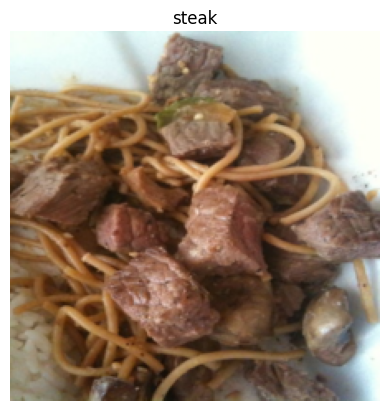

In [12]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

# **Calculating Patch Embedding Input/Output Shape**

In [13]:
# Calculating the patches ofimage
height = 224 # H
width = 224  # W
color_channels = 3 # C
patch_size = 16 # P

#calculating N (Number of patches)
Number_of_patches =  int((height * width)/patch_size**2)

Number_of_patches


196

## Image Transformation

### Input
The image starts as 2D with size:
$$
H \times W \times C
$$

### Output
The image gets converted to a sequence of flattened 2D patches with size:
$$
N \times (P^2 \cdot C)
$$




In [14]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (Number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


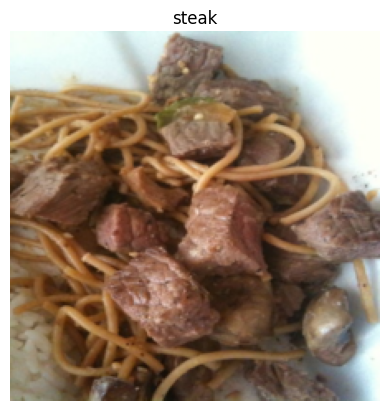

In [15]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

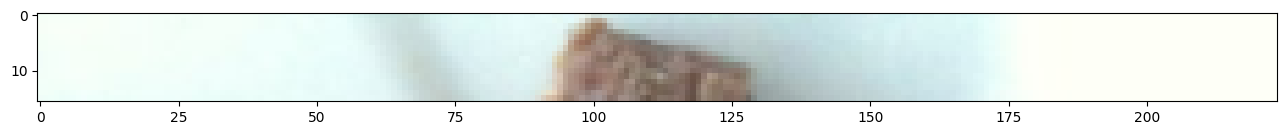

In [16]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

 Number of patches in a row : 14.0 , patch size is : (16 ,  16) pixels


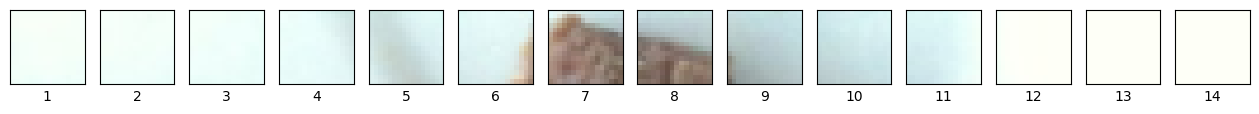

In [17]:
# Setup hyperparameters and make sure img_size and patch_size are compatible

img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0
print(f" Number of patches in a row : {num_patches} , patch size is : ({patch_size} ,  {patch_size}) pixels")

# create subplots
fig , axs = plt.subplots(
                  nrows = 1,
                  ncols = img_size // patch_size,
                  figsize = (patch_size, patch_size),
                  sharex = True,
                  sharey = True)

# Iterate through number of patches in the top row
for i , patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch: patch+patch_size, :])
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

 Number of patches in a row : 14.0 , patch size is : (16 ,  16) pixels


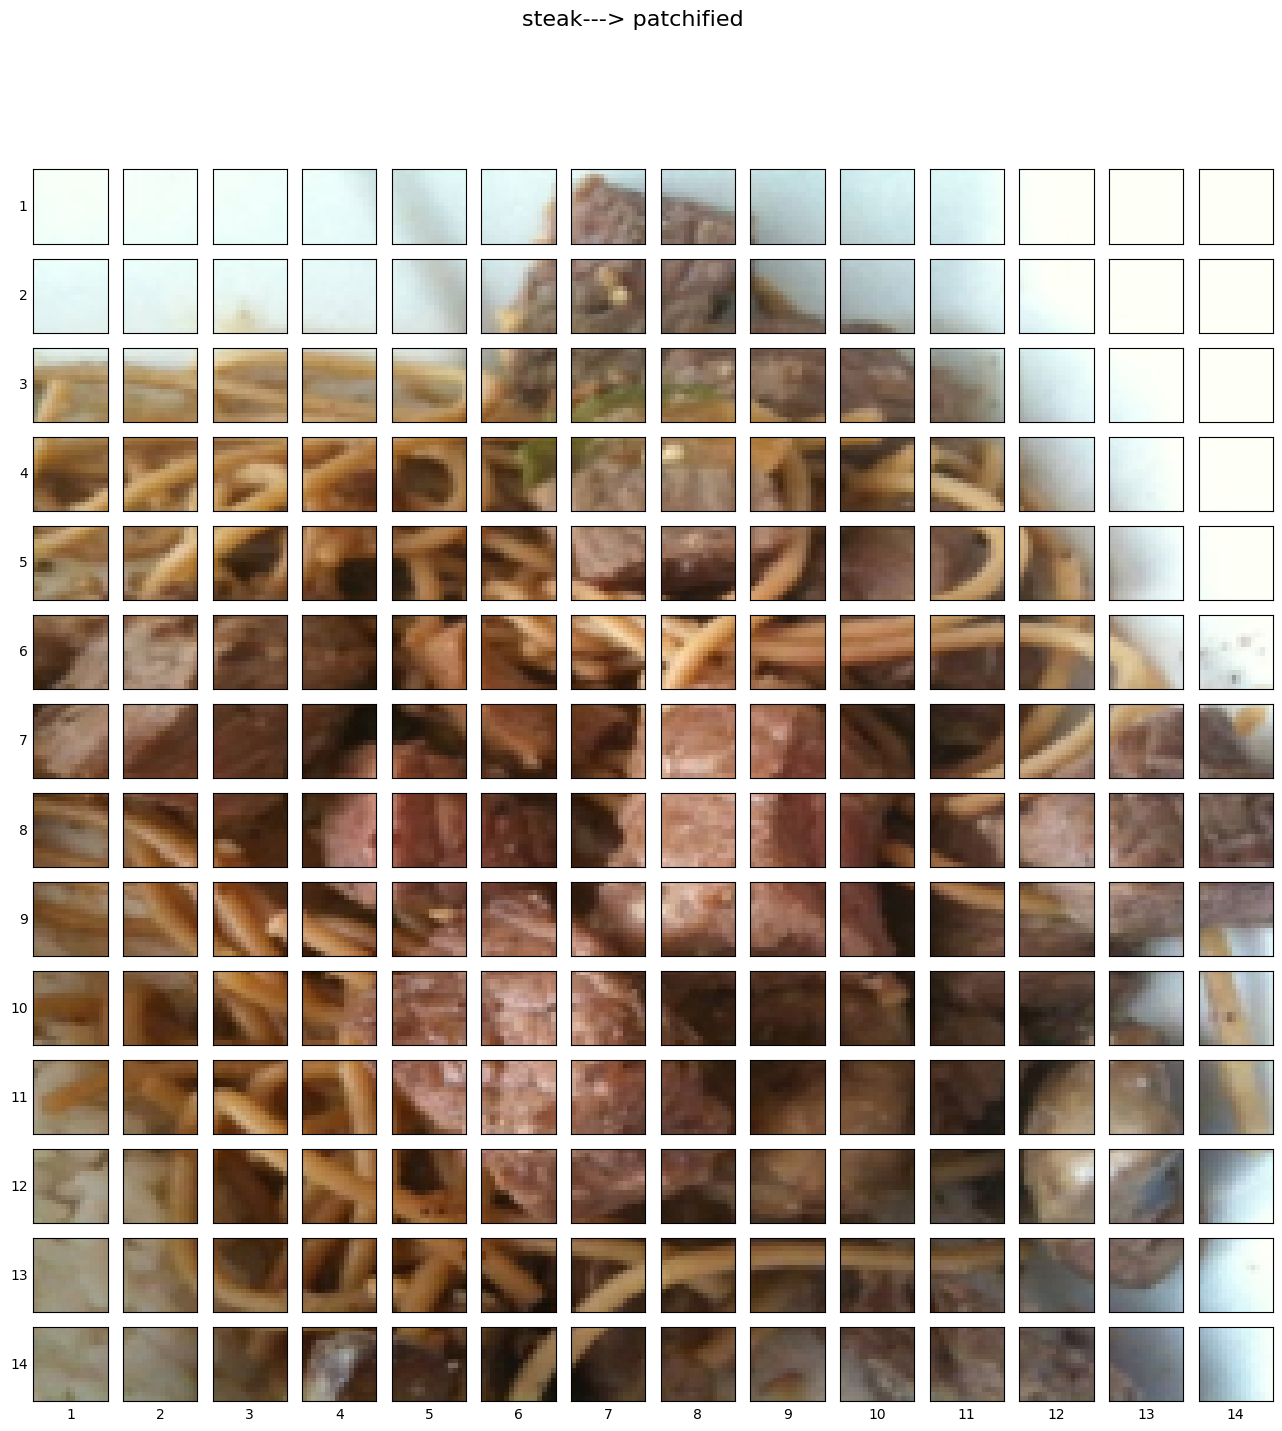

In [18]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0
print(f" Number of patches in a row : {num_patches} , patch size is : ({patch_size} ,  {patch_size}) pixels")

# create subplots
fig , axs = plt.subplots(
                  nrows = img_size //patch_size,
                  ncols = img_size // patch_size,
                  figsize = (patch_size, patch_size),
                  sharex = True,
                  sharey = True)
for i, patch_height in enumerate(range(0, img_size, patch_size)):
  for j , patch_width in enumerate(range(0, img_size, patch_size)):

    # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
    axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size, patch_width:patch_width+patch_size, :])

    # Set up label information, remove the ticks for clarity and set labels to outside
    axs[i,j].set_ylabel(i+1, rotation= "horizontal", horizontalalignment = "right", verticalalignment= "center")
    axs[i,j].set_xlabel(j+1)
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    axs[i,j].label_outer()


# setup the super title
fig.suptitle(f"{class_names[label]}---> patchified", fontsize= 16)
plt.show()



# ***`Creating image patches with torch.nn.Conv2d()`***

In [19]:
from torch import nn
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels:int=3, patch_size:int = 16, embedding_dim:int = 768):
    super().__init__()
    #Create a layer to turn image into patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    # create flatten layer to conert patch feature into single dimension
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    # create forward method
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0

    # Perform the forward pass
    x_patcher = self.patcher(x)

    x_flatten = self.flatten(x_patcher)

    # Make sure the output shape has the right order
    return x_flatten.permute(0,2,1) # djust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]


In [20]:
image.unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [21]:
# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [22]:
16*16*3

768

In [23]:
14*14

196

# **Summary of PatchEmbedding layer.**

In [24]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# # Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=25,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]          [1, 196, 768]             --                        True
├─Conv2d (patcher)                       [1, 3, 224, 224]          [1, 768, 14, 14]          590,592                   True
├─Flatten (flatten)                      [1, 768, 14, 14]          [1, 768, 196]             --                        --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

# **Creating the Class Token Embedding**

* To "prepend a learnable embedding to the sequence of embedded patches" we need to create a learnable embedding in the shape of the embedding_dimension (D
𝐷
) and then add it to the number_of_patches dimension.

 * **Note:** Here we're only creating the class token embedding as torch.ones() for demonstration purposes, in reality, you'd likely create the class token embedding with torch.randn() (since machine learning is all about harnessing the power of controlled randomness, you generally start with a random number and improve it over time).

In [25]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
# [batch_size, number_of_tokens, embedding_dimension]
# require_grad is True to make sure the embedding is learnable

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim), requires_grad=True)

# show the first 10 examples
print(class_token[:,:,:10])

#vprint the shape of class token

print(f"class_token shape is :  {class_token.shape}---[batch_size, number_of_tokens, embedding_dimension]")


tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
class_token shape is :  torch.Size([1, 1, 768])---[batch_size, number_of_tokens, embedding_dimension]


**Note:** See how the number_of_tokens dimension of class_token is 1 since we only want to prepend one class token value to the start of the patch embedding sequence.

Now we've got the class token embedding, let's prepend it to our sequence of image patches, patch_embedded_image.

We can do so using torch.cat() and set dim=1 (so class_token's number_of_tokens dimension is preprended to patch_embedded_image's number_of_patches dimension).

In [26]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")


tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.0654,  0.8974,  0.5116,  ...,  0.1945, -0.4409, -0.4883],
         [ 0.0618,  0.8900,  0.5079,  ...,  0.2039, -0.4457, -0.4917],
         ...,
         [ 0.0711,  0.3132,  0.1623,  ...,  0.0104, -0.1457, -0.1902],
         [-0.0729,  0.4568,  0.2159,  ...,  0.0568, -0.1318, -0.1963],
         [-0.0746,  0.7988,  0.3842,  ...,  0.2587, -0.2774, -0.3661]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [27]:
patch_embedded_image

tensor([[[ 0.0654,  0.8974,  0.5116,  ...,  0.1945, -0.4409, -0.4883],
         [ 0.0618,  0.8900,  0.5079,  ...,  0.2039, -0.4457, -0.4917],
         [ 0.0617,  0.8853,  0.5090,  ...,  0.2083, -0.4471, -0.4781],
         ...,
         [ 0.0711,  0.3132,  0.1623,  ...,  0.0104, -0.1457, -0.1902],
         [-0.0729,  0.4568,  0.2159,  ...,  0.0568, -0.1318, -0.1963],
         [-0.0746,  0.7988,  0.3842,  ...,  0.2587, -0.2774, -0.3661]]],
       grad_fn=<PermuteBackward0>)

In [28]:
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

# **Creating Positional Embedding**

In [29]:
# Calculate N (Number of Patches)
num_of_patches = int((height * width)// patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
positional_embedding = nn.Parameter(torch.ones(1, num_of_patches +1, embedding_dimension), requires_grad=True)

print(positional_embedding[:,:10,:10])
print(positional_embedding.shape)


tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
torch.Size([1, 197, 768])


In [30]:
# Added Positional Embedding to patch_embedded_image_with_class_embedding

pach_and_position_embedding = patch_embedded_image_with_class_embedding + positional_embedding
# print first 10
print(pach_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {pach_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.0654, 1.8974, 1.5116,  ..., 1.1945, 0.5591, 0.5117],
         [1.0618, 1.8900, 1.5079,  ..., 1.2039, 0.5543, 0.5083],
         ...,
         [1.0711, 1.3132, 1.1623,  ..., 1.0104, 0.8543, 0.8098],
         [0.9271, 1.4568, 1.2159,  ..., 1.0568, 0.8682, 0.8037],
         [0.9254, 1.7988, 1.3842,  ..., 1.2587, 0.7226, 0.6339]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [31]:
pach_and_position_embedding.shape

torch.Size([1, 197, 768])

# ***Putting it all together: from image to embedding***

In [32]:
torch.manual_seed(42)

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


# **Multi-Head Attention (MSA)**

In [33]:
# MultiheadSelfAttentionBlock inherited from nn.Module

class MultiheadSelfAttentionBlock(nn.Module):

  # Initialize the class with hyperparameters
  def __init__(self, embedding_dim:int=768, num_heads:int=12, atten_dropout:float=0):
    super().__init__()

      # Create the Norm layer (LN)
    self.normlayer = nn.LayerNorm(normalized_shape=embedding_dim)
    #create the MSA(Multi Head Attention) layer
    self.multihead_attention = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=atten_dropout,
                                                    batch_first=True)

  #Create forward method to pass the data through layers
  def forward(self, x):
    x = self.normlayer(x)
    output_atten, _ = self.multihead_attention(query=x, key=x, value= x, need_weights = False)
    return output_atten



In [34]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock()

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(pach_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


# **MLP BLOCK**

In [35]:
class MlpBlock(nn.Module):
  def __init__(self, embedding_dim:int= 768, mlp_size:int=3072, dropout:float = 0.1):
    super().__init__()

    # create the normalization layer
    self.normlayer = nn.LayerNorm(normalized_shape=embedding_dim)

    # create the mlp
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim, out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size, out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  # create the forward method to pass the data to layers
  def forward(self, x):
    x = self.normlayer(x)
    x = self.mlp(x)
    return x

In [36]:
# Create an instance of MLPBlock
mlp_block = MlpBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


# **Transformer Encoder**

* The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski & Auli, 2019).

* **x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> .**
* One of the main ideas behind residual connections is that they prevent weight values and gradient updates from getting too small and thus allow deeper networks and in turn allow deeper representations to be learned.

In [37]:
class TxrEncoderBlock(nn.Module):
  def __init__(self,embedding_dim:int=768,
               num_heads:int=12,
               atten_dropout:float=0,
               mlp_size:int=3072,
               mlp_dropout:float=0.1):
    super().__init__()

    # create the MSA Block
    self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 atten_dropout=atten_dropout)

    # create the MLP Block
    self.mlp_block = MlpBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  # create the forward method to pass the data from MSA and MLP blocks
  def forward(self, x):
    # Create residual connection for MSA block (add the input to the output)
    x = self.msa_block(x) + x
    ## 6. Create residual connection for MLP block (add the input to the output)
    x = self.msa_block(x) + x

    return x



In [38]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TxrEncoderBlock()

# Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TxrEncoderBlock (TxrEncoderBlock)                       [1, 197, 768]        [1, 197, 768]        4,723,968            True
├─MultiheadSelfAttentionBlock (msa_block)               [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (normlayer)                            [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attention)         --                   [1, 197, 768]        2,362,368            True
├─MultiheadSelfAttentionBlock (msa_block)               [1, 197, 768]        [1, 197, 768]        (recursive)          True
│    └─LayerNorm (normlayer)                            [1, 197, 768]        [1, 197, 768]        (recursive)          True
│    └─MultiheadAttention (multihead_attention)         --                   [1, 197, 768]        (recursive)          True
Tot

# ***torch.nn.TransformerEncoderLayer()***

In [39]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [40]:
# Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

# **Putting it all together to create ViT**

In [41]:
class Vit(nn.Module):
  """
   Creates a Vision Transformer architecture with ViT-Base hyperparameters by default.
   """
    # Initialize the class with hyperparameters from Table 1 and Table 3
  def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=32): # Default for ImageNet but can customize this

    super().__init__()

    # Image_size should be divisible by patch_size

    assert img_size % patch_size == 0
    print(f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}.")

    #calculating N (Number of patches)
    self.num_patches =  int((height * width)/patch_size**2)

    # Create learnable class embedding
    self.class_embedding = nn.Parameter(data = torch.randn(1, 1, embedding_dim), requires_grad=True)

    # Create position embedding
    self.position_embedding = nn.Parameter(data = torch.randn(1, self.num_patches+1, embedding_dim), requires_grad=True)

    # create embedding dropout
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # create patch_embedding
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size= patch_size,
                                          embedding_dim=embedding_dim)

    # Create Transformer Encoder blocks (Transformer Encoder blocks can be stacked using nn.Sequential())
    self.transformer_encoder_block = nn.Sequential(*[TxrEncoderBlock(embedding_dim=embedding_dim,
                                                                     num_heads=num_heads,
                                                                     mlp_size=mlp_size,
                                                                     mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])


    # create classifier head()
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes))

  # create a forward method
  def forward(self, x):
    #Get the batch_size
    batch_size = x.shape[0]

    #Create class token embedding and expand it to match the batch size
    class_token = self.class_embedding.expand(batch_size, -1, -1)

    # create patch embedding
    x = self.patch_embedding(x)

    # cancatenate class_embedding(class_token ) with patch_embedding
    x = torch.cat((class_token, x), dim=1)

    # add position embedding
    x = self.position_embedding + x

    # run embedding dropout
    x = self.embedding_dropout(x)

    # pass, class_embedding, patch embedding and position embedding tthrough transformer encoder
    x = self.transformer_encoder_block(x)

    # Put 0 index logit through classifier
    x = self.classifier(x[:, 0])

    return x


**Notice how the first dimension gets expanded to the batch size and the other dimensions stay the same (because they're inferred by the "-1" dimensions in .expand(batch_size, -1, -1)).**

In [42]:
class_embedding_single = nn.Parameter(data = torch.randn(1, 1,3))
print(f"class_embeding_single {class_embedding_single} and shape is {class_embedding_single.shape}")

print(f"class_embedding_single is expanded ")
class_embedding_xpand = class_embedding_single.expand(5, -1,-1)
print(f"class_embeding_single_expand {class_embedding_xpand} and shape is {class_embedding_xpand.shape}")

class_embeding_single Parameter containing:
tensor([[[-1.0150, -0.1752,  0.6241]]], requires_grad=True) and shape is torch.Size([1, 1, 3])
class_embedding_single is expanded 
class_embeding_single_expand tensor([[[-1.0150, -0.1752,  0.6241]],

        [[-1.0150, -0.1752,  0.6241]],

        [[-1.0150, -0.1752,  0.6241]],

        [[-1.0150, -0.1752,  0.6241]],

        [[-1.0150, -0.1752,  0.6241]]], grad_fn=<ExpandBackward0>) and shape is torch.Size([5, 1, 3])


In [43]:
torch.manual_seed(42)

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = Vit(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

Image size must be divisible by patch size, image size: 224, patch size: 16.


tensor([[-0.0417,  1.2259,  0.8228]], grad_fn=<AddmmBackward0>)

In [44]:
from torchinfo import summary

# # Print a summary of our custom ViT model using torchinfo
summary(model=vit,
         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"]
 )

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
Vit (Vit)                                                         [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                                [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                           [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                          [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder_block)                          [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TxrEncoderBlock (0)                                   

# ***Setup Training & Testing Steps for Vit Model***

In [45]:
import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

# 1. Training step

def train_step(model:torch.nn.Module,
               loss_fn:nn.Module,
               dataloader:torch.utils.data.dataloader,
               optimizer:torch.optim.Optimizer,
               device:torch.device)->Tuple[float, float]:
  # put model on training mode
  model.train()

  #setup the loss and accuracy variable
  train_loss, train_acc = 0,0

  # loop through dataloader
  for batch, (X,y) in enumerate(dataloader):

    # send data to target device
    X, y = X.to(device), y.to(device)

    # forward pass
    y_pred = model(X)

    #  calculate and accumulate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()


    #optimizer zero_grad
    optimizer.zero_grad()

    # loss backward
    loss.backward()

    #optimizer step
    optimizer.step()

    # calculate and accumulate the accuracy across all batches
    y_pred_class= torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/(len(y_pred))

  #adjust average loss and accuracy per batch
  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)

  return train_loss, train_acc



In [49]:
#2. Testing step

def test_step(model:torch.nn.Module,
              loss_fn:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              device:torch.device)-> Tuple[float, float]:


  #put model on evaluation mode
  model.eval()
  # setup loss and accuracy
  test_loss, test_acc = 0,0

  # set the inference context manager
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):

      # Data sent on target device
      X, y = X.to(device), y.to(device)

      #forwrd pass
      y_pred_logits = model(X)

      # calculate and accumulate the test loss
      loss = loss_fn(y_pred_logits, y)
      test_loss += loss.item()

      # calculate and accumulate the test accuracy
      test_pred_labels = y_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/(len(test_pred_labels)))

  # Adjust test loss and accuracy per batch
  test_loss = test_loss/(len(dataloader))
  test_acc = test_acc/(len(dataloader))

  return test_loss, test_acc


In [52]:
#3 Testing_step and Train_step are combined
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.dataloader,
          test_dataloader:torch.utils.data.dataloader,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module,
          device:torch.device,
          epochs:int,
          )->Dict[str, List]:

  # setup empty dict for loss and accuracy
  results = {
      "train_loss":[],
       "train_acc":[],
      "test_loss": [],
       "test_acc": []
  }

  # put the model on target device
  model.to(device)

  # Loop through traing and testing for number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       optimizer=optimizer,
                                       loss_fn=loss_fn,
                                       device=device
                                       )

    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # show the values of loss and accuracy
    print(f"epoch: {epoch} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | test_loss:{test_loss:.4f}| test_acc: {test_acc:.4f}")
    # update results
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  return results

In [54]:
# setup the optimizer and loss function
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.3)

loss_fn = torch.nn.CrossEntropyLoss()



# Train the model and save the results into dictionary
results = train(model=vit,
                optimizer= optimizer,
                loss_fn = loss_fn,
                train_dataloader = train_dataloader,
                test_dataloader= test_dataloader,
                device = device,
                epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

# ***Plot the Loss curve of Model***

In [ ]:
def plot_loss_curve(results):

  train_loss = results["train_loss"]
  train_acc  =  results["train_acc"]
  test_loss   = results["test_loss"]
  test_acc   = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))

  # plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs,train_loss, label = "train_loss")
  plt.plot(epochs, test_loss, label = "test_loss")
  plt.label("Loss")
  plt.xlabel("epochs")
  plt.legend

  # plot accuracy

  plt.subplot(1,2,2)
  plt.plot(epochs, train_acc, label = "train_acc")
  plt.plot(epochs, test_acc, label= "test_acc")
  plt.label("Accuracy")
  plt.xlabel("epochs")
  plt.legend()


plot_loss_curve(results)

# **Getting a pretrained ViT model and creating a feature extractor¶**

* Get a pretrained ViT model from torchvision.models.
* we'll get the pretrained ViT-Base with patch size 16 from torchvision.models and prepare it for our FoodVision Mini use case by turning it into a feature extractor transfer learning model.

* Get the pretrained weights for ViT-Base trained on ImageNet-1k from torchvision.models.ViT_B_16_Weights.DEFAULT (DEFAULT stands for best available).
* Setup a ViT model instance via torchvision.models.vit_b_16, pass it the pretrained weights step 1 and send it to the target device.
* Freeze all of the parameters in the base ViT model created in step 2 by setting their requires_grad attribute to False.
* Update the classifier head of the ViT model created in step 2 to suit our own problem by changing the number of out_features to our number of classes (pizza, steak, sushi).







In [57]:
# Get pretrained weights
pretrained_Vit_Weights =  torchvision.models.ViT_B_16_Weights.DEFAULT

# Instantiate the instance of pretarined model with pretrained_Vit_Weights
pretrained_vit_base = torchvision.models.vit_b_16(weights=pretrained_Vit_Weights).to(device)

# Freeze the base parameters

for parameters in pretrained_vit_base.parameters():
  parameters.requires_grad = False

#hange the classifier head (set the seeds to ensure same initialization with linear head)

pretrained_vit_base.heads = nn.Linear(in_features=768, out_features= len(class_names)).to(device)
#pretrained_vit_base


In [56]:
## Print a summary using torchinfo
summary(model=pretrained_vit_base,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [58]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_Vit_Weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [59]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [ ]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit_base.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model

pretrained_vit_results = train(model=pretrained_vit_base,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

In [61]:
def plot_loss_curve(results):

  train_loss = results["train_loss"]
  train_acc  =  results["train_acc"]
  test_loss   = results["test_loss"]
  test_acc   = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))

  # plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs,train_loss, label = "train_loss")
  plt.plot(epochs, test_loss, label = "test_loss")
  plt.label("Loss")
  plt.xlabel("epochs")
  plt.legend

  # plot accuracy

  plt.subplot(1,2,2)
  plt.plot(epochs, train_acc, label = "train_acc")
  plt.plot(epochs, test_acc, label= "test_acc")
  plt.label("Accuracy")
  plt.xlabel("epochs")
  plt.legend()

plot_loss_curve(pretrained_vit_results)

NameError: name 'pretrained_vit_results' is not defined

In [60]:
from typing import List
import torchvision


def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",):


    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.0

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )  # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

In [ ]:
import requests

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

In [ ]:
# Predict on custom image
pred_and_plot_image(model=pretrained_vit_results,
                    image_path=custom_image_path,
                    class_names=class_names)